# Gradient-based optimization

## Overview

Mitsuba 3 can be used to solve inverse problems involving light using a technique known as *differentiable rendering*. It interprets the rendering algorithm as a function $f(\mathbf{x})$ that converts an input $\mathbf{x}$ (the scene description) into an output $\mathbf{y}$ (the rendering). This function $f$ is then mathematically differentiated to obtain $\frac{d\mathbf{y}}{d\mathbf{x}}$, providing a first-order approximation of how a desired change in the output $\mathbf{y}$ (the rendering) can be achieved by changing the inputs $\mathbf{x}$ (the scene description). Together with a differentiable *objective function* $g(\mathbf{y})$ that quantifies the suitability of tentative scene parameters, a gradient-based optimization algorithm such as stochastic gradient descent or Adam can then be used to find a sequence of scene parameters $\mathbf{x_0}$, $\mathbf{x_1}$, $\mathbf{x_2}$, etc., that successively improve the objective function. In pictures:

![](autodiff_figure.jpg)


In this tutorial, we will build a simple example application that showcases differentiation and optimization of a light transport simulation. Our experiment will be very simply: we will first render a reference image of the Cornell Box scene before modifying the color of the red wall in that scene (e.g. to blue). Then we will try to recover the original color using differentiation along with the reference image previoulsy generated.

Mitsuba’s ability to automatically differentiate entire rendering algorithms builds on differentiable JIT array types provided by the Dr.Jit library. Those are explained in the [Dr.Jit documentation][1]. The linked document also discusses key differences compared to superficially similar frameworks like PyTorch and TensorFlow. For *automatic differentiation* (AD), Dr.Jit records and simplifies computation graphs and uses them to propagate derivatives in forward or reverse mode. Before getting further into this tutorial, we recommend that you familiarize yourself this document.

<div class="admonition important alert alert-block alert-success">

🚀 **What will you learn?**
    
<ul>
  <li>Passing scene arguments when loading an XML file</li>
    <li>Build an optimization pipeline using the <code>Optimizer</code> classes</li>
  <li>Perform gradient-based optimization using automatic differentiation</li>
</ul>
    
</div>

    
[1]: https://drjit.readthedocs.io/en/master/

## Setup

In order to use the automatic differentiation, we need to enable a variant that supports it. Those are the ones containing `_ad` after the backend description. E.g. `cuda_ad_rgb`, `llvm_ad_rgb`, ... 

In [1]:
import drjit as dr
import mitsuba as mi

mi.set_variant('llvm_ad_rgb')

## Scene loading

Before loading the scene, let's note that in `cbox.xml` we expose some variables at the top of the file:

```xml
  <default name="spp" value="128"/>
  <default name="res" value="256"/>
  <default name="max_depth" value="6"/>
  <default name="integrator" value="path"/>
```

Those variables are later referenced in the XML file as explained in the [documentation][1] and can be assigned directly from Python when loading the scene, this using keyword arguments in the `load_file()` function. This helpful feature let us change the film resolution and integrator type for this tutorial without editing the XML file.

For differentiable rendering application, we recommand to use the [<code>prb</code>][2] integrator introduced by <cite data-cite="Vicini2021">Vicini et al. (2021)</cite> which is equivalent to the `path` integrator for primal rendering.

[1]: https://mitsuba3.readthedocs.io/en/latest/src/key_topics/scene_format.html
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb

In [2]:
scene = mi.load_file('../../scenes/cbox.xml', res=128, integrator='prb')

## Reference image

We render a reference image of the original scene that will later be used in the objective function for the optimization. Ideally, this reference image should expose very little noise as it will pertube optimization process otherwise. For that reason we render this image with a higher sample count.

In [3]:
image_ref = mi.render(scene, seed=0, spp=512)
mi.util.convert_to_bitmap(image_ref)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Initial state

Using the `traverse` mechanism, we can pick a parameter to optimize and change its value. The goal of the optimization process will be to recover the original value of this parameter using a gradient descent. In this tutorial we are going to work with the `'red.reflectance.value'` parameter which controls the albedo color of the red wall in the scene.

For later comparison, we also save the original value of the scene parameter.

In [4]:
params = mi.traverse(scene)

key = 'red.reflectance.value'

# Save the original value
param_ref = mi.Color3f(params[key])

# Set another color value and update the scene
params[key] = mi.Color3f(0.01, 0.2, 0.9)
params.update()

As expected, when rendering the scene again, the wall has changed color.

In [5]:
image_init = mi.render(scene, seed=0, spp=128)
mi.util.convert_to_bitmap(image_init)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

## Optimization

For gradient-based optimization, Mitsuba ships with standard optimizers including *Stochastic Gradient Descent* ([<code>SGD</code>][1]) with and without momentum, as well as [<code>Adam</code>][2] <cite data-cite="kingma2014adam">[KB14]</cite>. We will instantiate the latter and optimize our scene parameter with a learning rate of `0.05`. 

During the optimization process, the optimizer will always perfom gradient steps on copies of the parameters to optimize. To propagate those changes to the scene, we need to call the `update()` method which will copy those values back into the `params` data structure passed in the constructor and internally call `params.update()`.

In the following code, the second line copies the scene parameter into the optimizer state, which will automatically enable gradient tracking on this variable. For more detailed explanation on how-to-use the optimizer classes, please refer to the dedicated [how-to-guide][1].

[1]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD
[2]: https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam
[3]: https://mitsuba3.readthedocs.io/en/latest/src/tutorials/how_to_guides/use_optimizers.html

In [6]:
opt = mi.ad.Adam(lr=0.05, params=params)
opt[key] = params[key]
opt.update()

At every iteration of the gradient descent, we will compute the derivatives of the scene parameters with respect to the objective function. In this simple experiment, we use the [*Mean Square Error*][1] objective function defined below.

[1]: https://en.wikipedia.org/wiki/Mean_squared_error

In [7]:
def MSE(image):
    return dr.hmean_async(dr.sqr(image - image_ref))

It is now time to actually perform the gradient-descent loop that executes 50 differentiable rendering iterations.

In [8]:
errors = []
for it in range(50):
    # Perform a differentiable rendering of the scene
    image = mi.render(scene, params, spp=4)
    
    # Evaluate the objective function
    loss = MSE(image)

    # Backpropagate through the whole process
    dr.backward(loss)

    # Optimizer: Take a gradient step
    opt.step()

    # Post-process the optimized parameters
    opt[key] = dr.clamp(opt[key], 0.0, 1.0)

    # Optimizer: Update the scene parameters
    opt.update()

    err_ref = dr.hsum(dr.sqr(param_ref - params[key]))
    print(f"Iteration {it:02d}: error={err_ref[0]:6f}", end='\r')
    errors.append(err_ref)

## Results

We can now render the scene again to check whether the optimization process successfully recovered the color of the red wall.

In [9]:
image_final = mi.render(scene, seed=0)
mi.util.convert_to_bitmap(image_final)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [128, 128],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 48 KiB of image data ]
]

We can also plot the error during each iteration. Note that it makes little sense to visualize the objective values, since differences between `image` and `image_ref` are by far dominated by Monte Carlo noise that is not related to the parameter being optimized. Since we know the “true” target parameter in this scene, we can validate the convergence of the iteration:

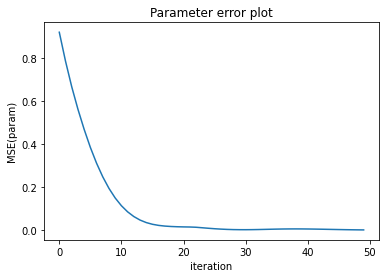

In [10]:
import matplotlib.pyplot as plt
plt.plot(errors)
plt.xlabel('iteration'); plt.ylabel('MSE(param)'); plt.title('Parameter error plot');

## See also

- [<code>mitsuba.ad.Optimizer</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Optimizer)
- [<code>mitsuba.ad.integrators.prb</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.integrators.prb)
- [<code>mitsuba.ad.SGD</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.SGD)
- [<code>mitsuba.ad.Adam</code>](https://mitsuba3.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.Adam)
- [<code>drjit.backward()</code>](...)

  